Generating tests for a varied set of documents, models and dimensions on the papers dataset

In [1]:
import pandas as pd
ai_set = pd.read_csv('../examples/datasets/ai_papers.csv')
dl_set = pd.read_csv('../examples//datasets/dl_papers.csv')
cv_set = pd.read_csv('../examples//datasets/cv_papers.csv')

In [2]:
# Pipeline para acelerar transformação para Dataset do HuggingFace

def hf_pipeline(data):
    from datasets import Dataset, ClassLabel

    unique_classes = data['label'].unique()

    dataframe = Dataset.from_pandas(data)
    class_label = ClassLabel(names=list(unique_classes))

    dataframe = dataframe.cast_column('label', class_label)

    return dataframe


def treat_datasets(n_papers=50):
    # Create new DataFrames with labels directly
    ai_papers = ai_set.iloc[:n_papers, :].assign(label="Artificial Intelligence")
    dl_papers = dl_set.iloc[:n_papers, :].assign(label="Digital Libraries")
    cv_papers = cv_set.iloc[:n_papers, :].assign(label="Computer Vision")

    # Concatenate
    papers = pd.concat([ai_papers, dl_papers, cv_papers], ignore_index=True)
    
    # Clean up columns
    papers = papers.drop(columns=['Unnamed: 0'], errors='ignore')
    
    # Select and rename columns
    abstracts = papers[['abstract', 'label']].rename(columns={'abstract': 'text'})
    
    return hf_pipeline(abstracts)



## Simple tests


In [3]:
from llm_mri import ActivationAreas, Evaluation
from llm_mri.dimensionality_reduction import PCA

abstracts = treat_datasets(50)
n_components = 30
pca = PCA(n_components = n_components)

model = 'distilbert-base-uncased'
# Beginning Visualization
llm_mri = ActivationAreas(model=model, device="cpu", dataset=abstracts, reduction_method=pca)

# Processing hidden states and activation areas
llm_mri.process_activation_areas() # Getting activation Areas and Reducing Dimensionality, as a torch dataset


/home/lipecorradini/.cache/pypoetry/virtualenvs/llm-mri-RE74i_Ji-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|██████████| 150/150 [00:33<00:00,  4.53 examples/s]


Obtaining grid

In [5]:
if (n_components <= 2): grid = llm_mri.get_grid(layer=6, category_name="Artificial Intelligence")


Text(0.5, 1.0, 'Dimensionality Reduction of DL graph by PCA')

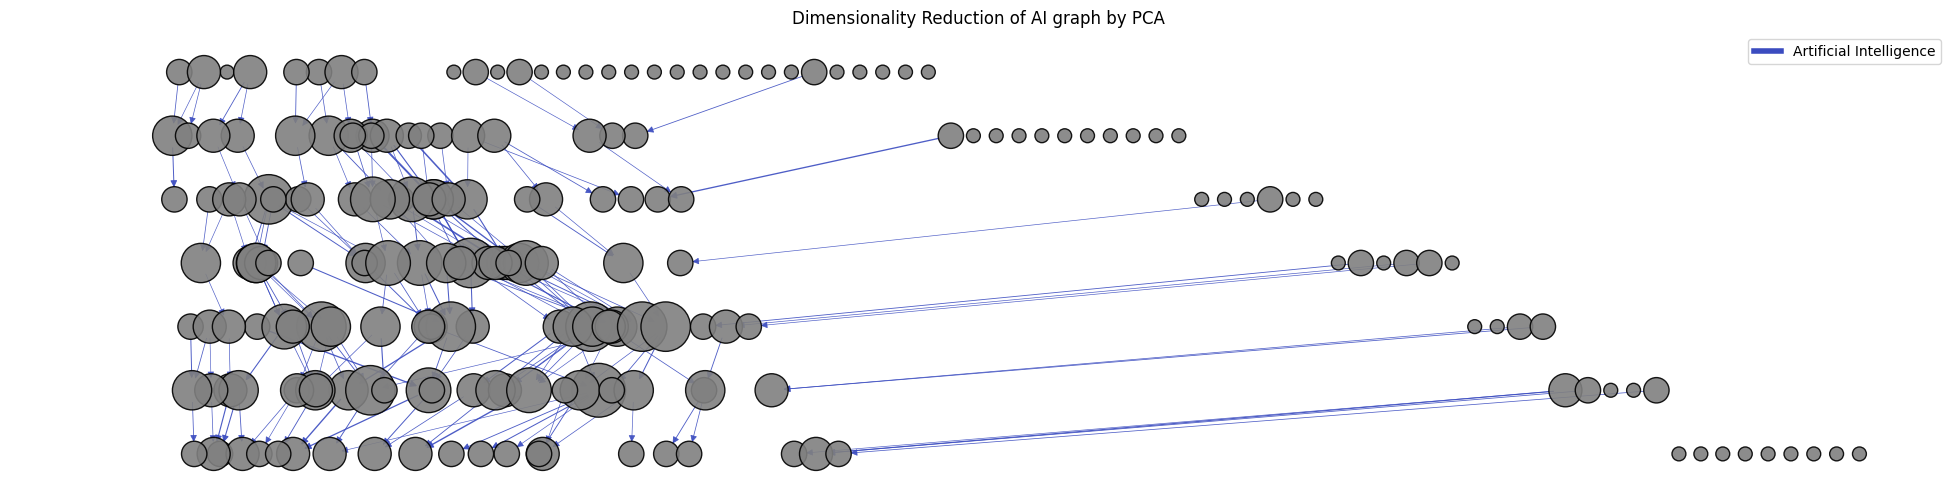

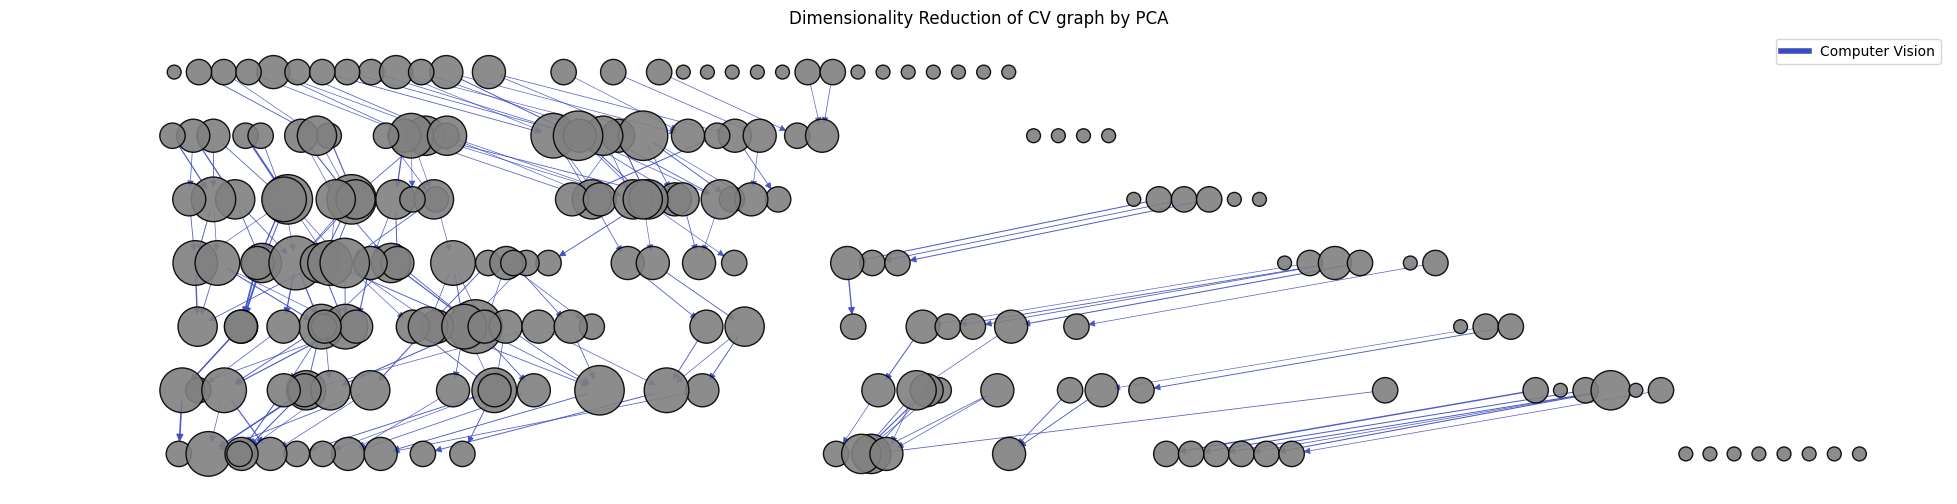

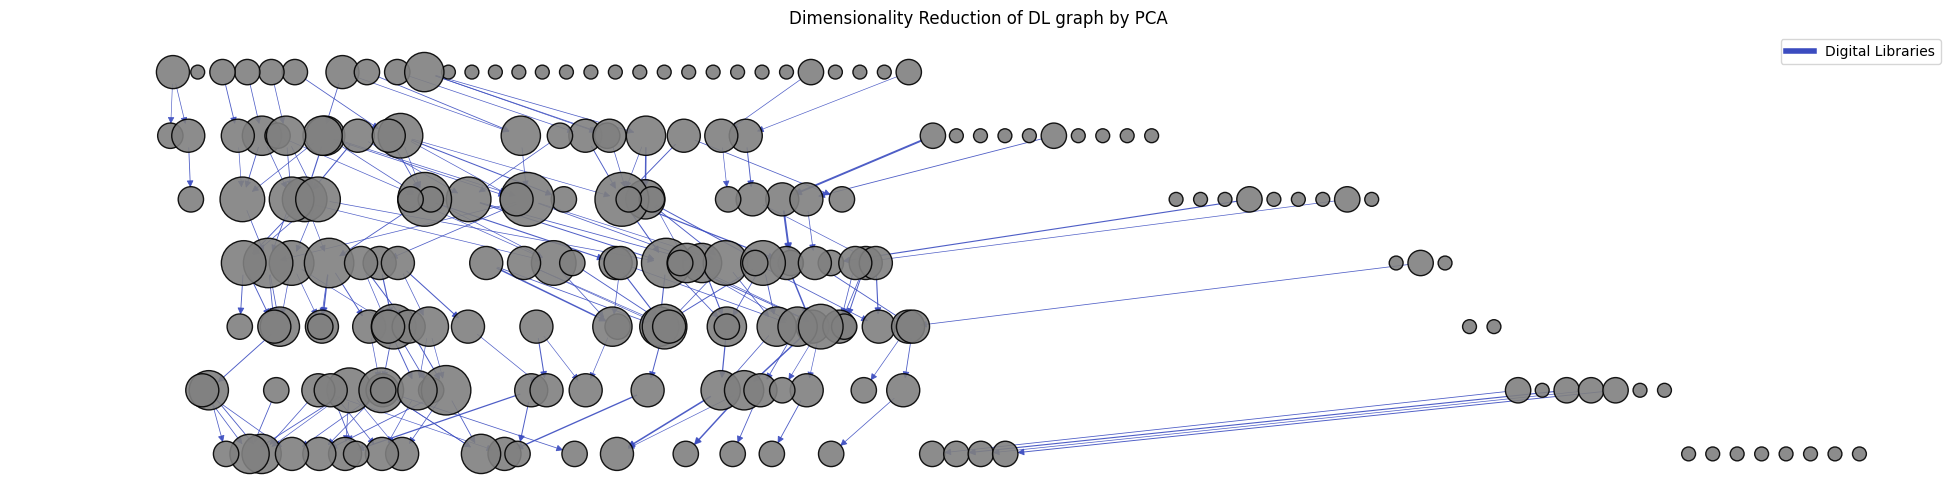

In [8]:

import matplotlib.pyplot as plt

# AI Grph
g_AI = llm_mri.get_graph("Artificial Intelligence") # Gets the graph for the true category
g_img = llm_mri.get_graph_image(g_AI, fix_node_dimensions=False)
plt.title("Dimensionality Reduction of AI graph by PCA")

# CV Graph
g_CV = llm_mri.get_graph("Computer Vision") # Gets the graph for the CV category 
g_img = llm_mri.get_graph_image(g_CV, fix_node_dimensions=False)
plt.title("Dimensionality Reduction of CV graph by PCA")

# DL Graph
g_DL = llm_mri.get_graph("Digital Libraries") # Gets the graph for the DL category
g_img = llm_mri.get_graph_image(g_DL, fix_node_dimensions=False)
plt.title("Dimensionality Reduction of DL graph by PCA")


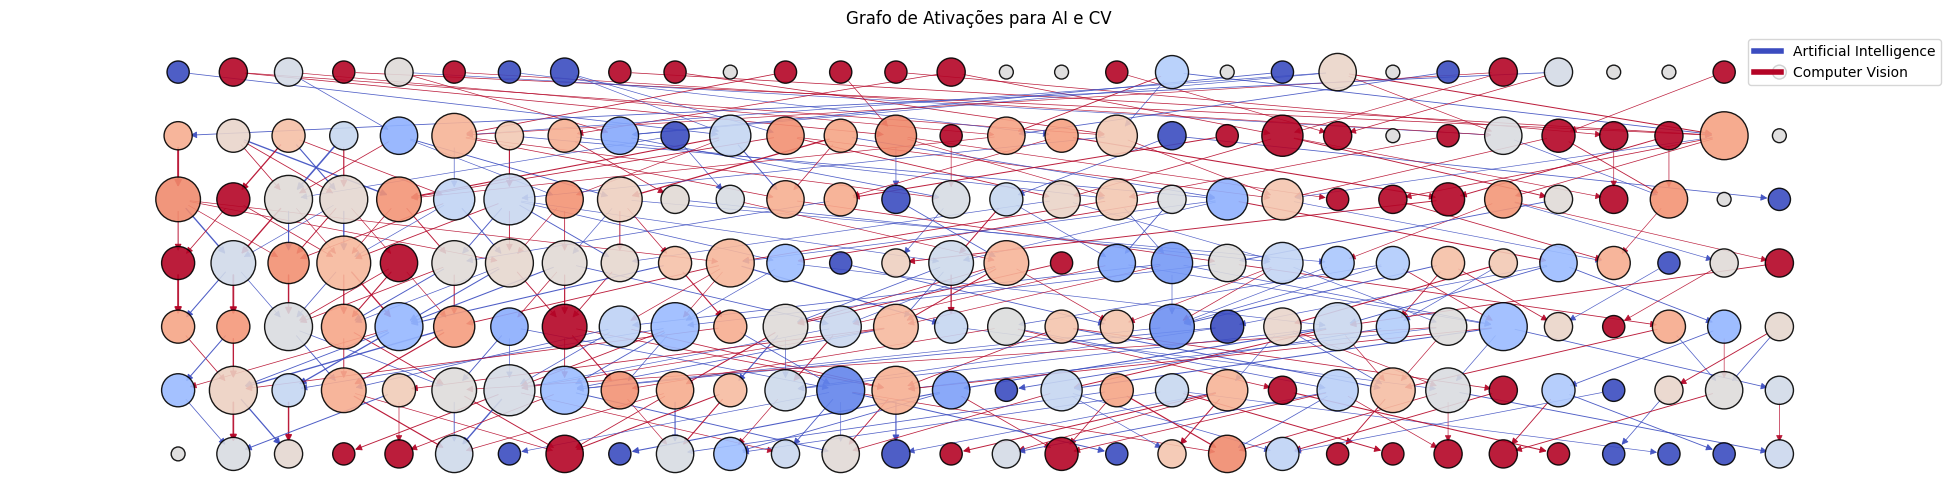

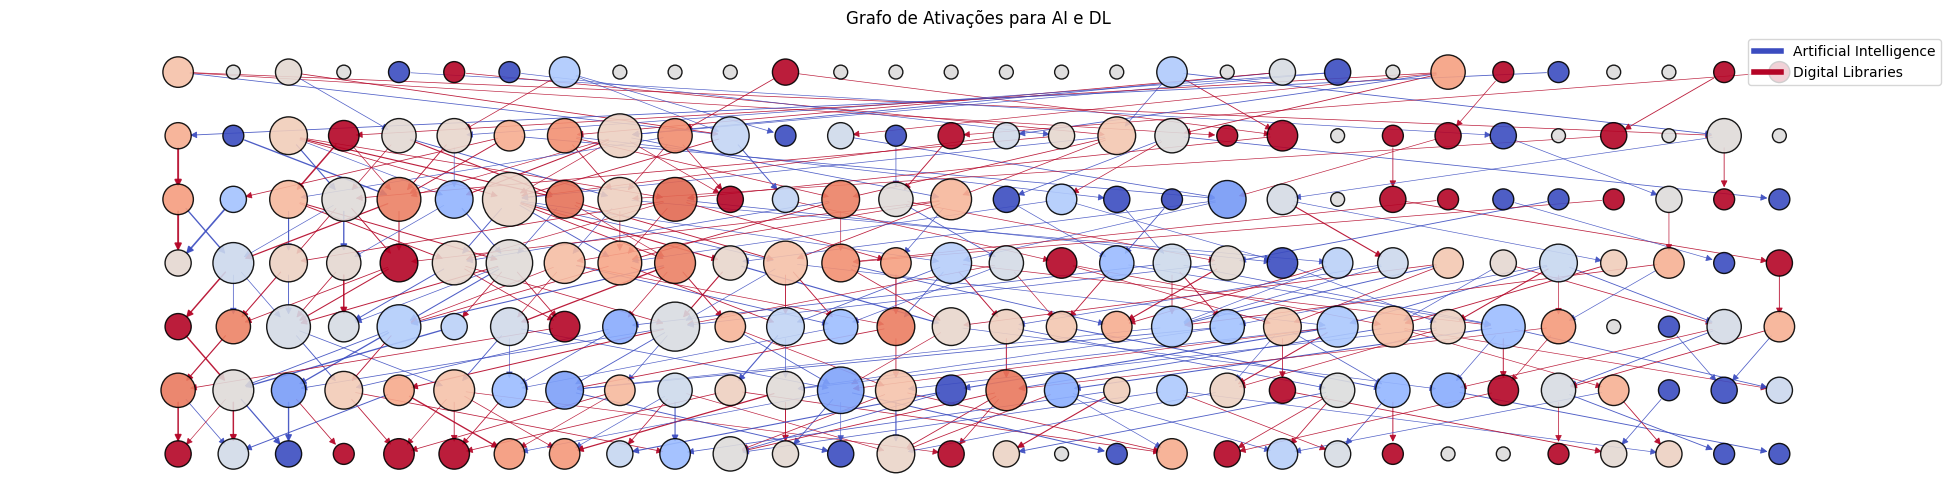

In [9]:

# Combined graphs
g_full = llm_mri.get_graph(["Artificial Intelligence", "Computer Vision"]) # Gets the graph for all categories
g_img = llm_mri.get_graph_image(g_full, fix_node_dimensions=True)
plt.title("Grafo de Ativações para AI e CV")


# Combined graphs
g_full = llm_mri.get_graph(["Artificial Intelligence", "Digital Libraries"]) # Gets the graph for all categories
g_img = llm_mri.get_graph_image(g_full, fix_node_dimensions=True)
plt.title("Grafo de Ativações para AI e DL")

plt.box(False)
plt.show()

## Testing time and space complexities

In [ ]:
from llm_mri import ActivationAreas, Evaluation
from llm_mri.dimensionality_reduction import PCA
import pandas as pd
import time
import warnings
import sys

# Suppress the SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# n_papers = [20, 50, 100]
# models = {'distilbert-base-uncased':'67M', 'bert-base-uncased':'110M', 'google-bert/bert-large-uncased':'330M'}
n_papers = [20, 50, 100]
# models = {'distilbert-base-uncased':'67M', 'bert-base-uncased':'110M'}

models = {'google-bert/bert-large-uncased':'330M'}
df_score = pd.DataFrame(columns=['model', 'documents', 'model_size', 'components', 'score', 'processing_time', 'hidden_states_size'])

for model in models:
    for paper in n_papers:
        print("----------------------------------------------------------------")
        print("Model - ", model, "with ", paper, " papers")
        abstracts = treat_datasets(n_papers=paper)
        pca = PCA(n_components=paper)
        
        llm_mri = ActivationAreas(model=model, device="cpu", dataset=abstracts, reduction_method=pca)
        
        # Time the processing
        start_time = time.time()
        llm_mri.process_activation_areas()
        processing_time = time.time() - start_time
        print(f"Total time: {processing_time:.2f} seconds")

        # Get hidden states dataset size in bytes
        hidden_states_size = sys.getsizeof(llm_mri.hidden_states_dataset)

        for components in [int(paper / 2), paper]:
            evaluation = Evaluation(llm_mri, n_components=components)
            results = evaluation.evaluate_model()
            # Append results to DataFrame
            new_evaluation = {
                'model': model,
                'documents': paper * 3,  # 3 datasets combined
                'model_size': models[model],
                'components': components,
                'score': results['f1_score_difference'],
                'processing_time': processing_time , # Add processing time,
                'hidden_states_size': hidden_states_size  # Add hidden states size
            }
            print(f"Evaluating model with {components} components: {results['f1_score_difference']:.3f} score!")
            
            df_score = pd.concat([df_score, pd.DataFrame([new_evaluation])], ignore_index=True)
        print("\n")

    df_score.to_csv(f'results_{model[:10]}.csv', index=False)
# Display the final DataFrame
print(df_score)

/home/lipecorradini/.cache/pypoetry/virtualenvs/llm-mri-RE74i_Ji-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

Plotting time visualization

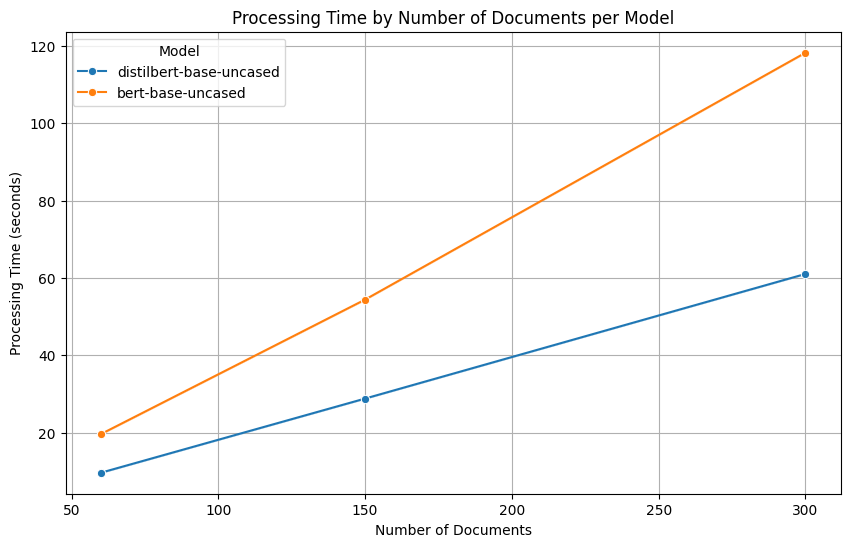

In [34]:
scores_distilbert = pd.read_csv('results_distilbert.csv')
scores_bert = pd.read_csv('results_bert-base-.csv')
df_score = scores_bert

# Line graph comparing processing time by number of documents per model
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_score, x='documents', y='processing_time', hue='model', marker='o')
plt.title('Processing Time by Number of Documents per Model')
plt.xlabel('Number of Documents')
plt.ylabel('Processing Time (seconds)')
plt.legend(title='Model')
plt.grid(True)


Plotting f1-score

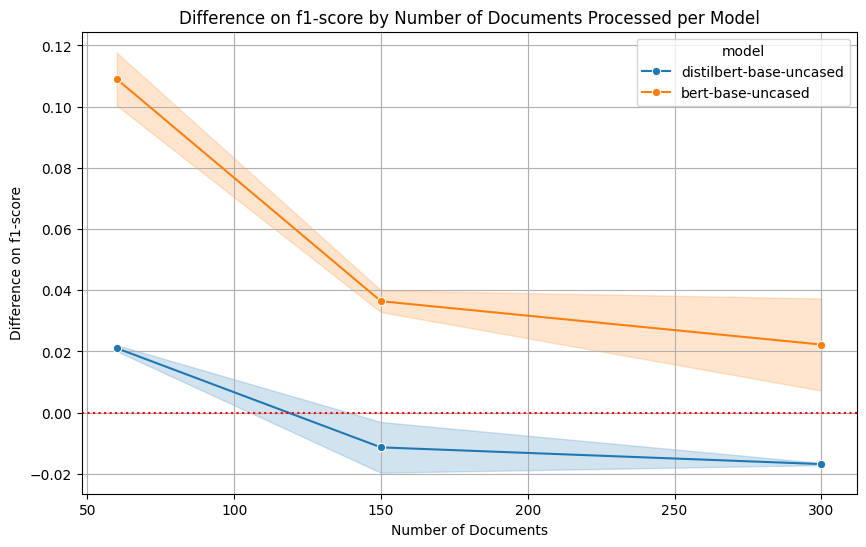

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_score, x='documents', y='score', hue='model', marker='o')
plt.title('Difference on f1-score by Number of Documents Processed per Model')
plt.xlabel('Number of Documents')
plt.ylabel('Difference on f1-score')
plt.legend(title='Model')
plt.axhline(y=0, linestyle='dotted', color='red')

plt.grid(True)
plt.show()